In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 43.7 MB/s eta 0:00:00


In [ ]:
import gurobipy as gp

In [ ]:
import os
import gurobipy as gp
from gurobipy import GRB, quicksum

params = {
    "WLSACCESSID": os.getenv("GRB_WLSACCESSID", '35a382ab-2f66-4f8c-93e5-29e3ae8a72c9'),
    "WLSSECRET":   os.getenv("GRB_WLSSECRET",   '697d9c6e-319b-4535-8f62-9fd78101f77d'),
    "LICENSEID":   int(os.getenv("GRB_LICENSEID", "2610074")),
    "OutputFlag":  0,
    "CSClientLog": 0,
}
env = gp.Env(params=params)
env.start()

Gurobi environment ready.


In [ ]:
!pip install yfinance --upgrade --no-cache-dir

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import yfinance as yf
from gurobipy import GRB

In [ ]:
def get_nasdaq100_tickers():

    url = 'https://en.wikipedia.org/wiki/Nasdaq-100'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                             'AppleWebKit/537.36 (KHTML, like Gecko) '
                             'Chrome/120.0.0.0 Safari/537.36'}

    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Raises an HTTPError if status != 200

    tables = pd.read_html(response.text)

    for table in tables:
      if 'Ticker' in table.columns:
        tickers = table['Ticker'].tolist()

        tickers = [str(ticker).strip() for ticker in tickers
                  if pd.notna(ticker) and ticker != 'nan']

    return tickers

tickers = get_nasdaq100_tickers()


def download_data(tickers, start_date, end_date):
    print(f"Downloading data from {start_date} to {end_date}.")
    data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=False)['Adj Close']
    returns = data.pct_change().dropna()
    return data, returns

def calculate_returns(prices):

    returns = prices.pct_change().dropna()
    return returns

/tmp/ipython-input-624488359.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [ ]:
prev_prices, prev_returns = download_data(tickers, '2024-01-01', '2024-12-30')
curr_prices, curr_returns = download_data(tickers, '2025-01-01', '2025-10-17')

index_ticker = "^NDX"

prev_index_prices, prev_index_returns = download_data(index_ticker, '2024-01-01', '2024-12-30')
curr_index_prices, curr_index_returns = download_data(index_ticker, '2025-01-01', '2025-10-17')


In [ ]:
prev_returns = prev_returns.loc[prev_returns.index.intersection(prev_index_returns.index)]
curr_returns = curr_returns.loc[curr_returns.index.intersection(curr_index_returns.index)]

q_2024 = prev_index_returns.loc[prev_returns.index, "^NDX"]
q_2025 = curr_index_returns.loc[curr_returns.index, "^NDX"]

In [ ]:
def select_m_stocks_by_IP(rho, m, tickers, env, verbose=False):
    """
    IP:
      max sum_{i,j} rho_ij * x_ij
      s.t. sum_j y_j = m
           sum_j x_ij = 1          ∀i
           x_ij <= y_j             ∀i,j
           x_ij, y_j ∈ {0,1}
    """
    n = rho.shape[0]
    mdl = gp.Model("stock_selection", env=env)
    if not verbose:
        mdl.Params.OutputFlag = 0

    #decision variables
    x = mdl.addVars(n, n, vtype=GRB.BINARY, name="x")  # x[i,j]
    y = mdl.addVars(n, vtype=GRB.BINARY, name="y")     # y[j]

    mdl.setObjective(quicksum(rho[i, j]*x[i, j] for i in range(n) for j in range(n)), GRB.MAXIMIZE)
    mdl.addConstr(quicksum(y[j] for j in range(n)) == m, name="choose_m")

    for i in range(n):
        mdl.addConstr(quicksum(x[i, j] for j in range(n)) == 1, name=f"assign_{i}")

    for i in range(n):
        for j in range(n):
            mdl.addConstr(x[i, j] <= y[j], name=f"link_{i}_{j}")

    mdl.optimize()

    selected_idx = [j for j in range(n) if y[j].X > 0.5]
    selected_tickers = [tickers[j] for j in selected_idx]
    rep_of_i = [max(range(n), key=lambda j: x[i, j].X) for i in range(n)]
    return selected_idx, selected_tickers, rep_of_i


In [ ]:
import numpy as np

def fit_weights_L1(R, q, sel_idx, env, nonneg=True, verbose=False):
    """
    Minimize sum_t | q_t - sum_j w_j R[t,j] |
    s.t. sum w = 1, w >= 0 (if nonneg)
    """
    T, N = R.shape
    J = sel_idx
    mdl = gp.Model("weight_fit_L1", env=env)
    if not verbose:
        mdl.Params.OutputFlag = 0

    w = mdl.addVars(J, lb=0.0 if nonneg else -GRB.INFINITY, name="w")
    e = mdl.addVars(T, lb=0.0, name="e")

    for t in range(T):
        mdl.addConstr(e[t] >= q[t] - quicksum(w[j]*R[t, j] for j in J))
        mdl.addConstr(e[t] >= -q[t] + quicksum(w[j]*R[t, j] for j in J))

    mdl.addConstr(quicksum(w[j] for j in J) == 1.0, name="budget")
    mdl.setObjective(quicksum(e[t] for t in range(T)), GRB.MINIMIZE)
    mdl.optimize()

    w_full = np.zeros(N)
    for j in J:
        w_full[j] = w[j].X
    L1 = sum(e[t].X for t in range(T))
    return w_full, L1


In [ ]:
rho = prev_returns.corr().fillna(0).clip(-1,1).values
tickers = list(prev_returns.columns)
sel_idx, sel_tickers, rep = select_m_stocks_by_IP(rho, m=5, tickers=tickers, env=env)

R24 = prev_returns.values   # T24 x N
R25 = curr_returns.values   # T25 x N
q24 = q_2024.values      # T24
q25 = q_2025.values      # T25

w_full_2024, in_sample_L1 = fit_weights_L1(R24, q24, sel_idx,  env=env, nonneg=True)

# out-of-sample L1 on 2025
pred25 = R25 @ w_full_2024
oos_L1 = np.sum(np.abs(q25 - pred25))
print(f"In-sample L1 (2024): {in_sample_L1:.6f}")
print(f"Out-of-sample L1 (2025): {oos_L1:.6f}")


In-sample L1 (2024): 0.961256
Out-of-sample L1 (2025): 0.879061


In [ ]:
results = []
for m in [5,10,20,30,40,50,60,70,80,90,100]:
    if m < R24.shape[1]:
        sel_idx, sel_tickers, rep = select_m_stocks_by_IP(rho, m, tickers, env=env)
    else:
        sel_idx = list(range(R24.shape[1]))

    w_full_2024, L1_2024 = fit_weights_L1(R24, q24, sel_idx, env=env, nonneg=True)
    L1_2025 = float(np.sum(np.abs(q25 - R25 @ w_full_2024)))
    results.append({"m": m, "L1_2024": L1_2024, "L1_2025": L1_2025})


In [ ]:
print(results)

[{'m': 5, 'L1_2024': 0.9612555167081824, 'L1_2025': 0.8790614162454773}, {'m': 10, 'L1_2024': 0.944813222374148, 'L1_2025': 0.8433910262566726}, {'m': 20, 'L1_2024': 0.7656499632002715, 'L1_2025': 0.663251879754424}, {'m': 30, 'L1_2024': 0.7161949257153843, 'L1_2025': 0.6555687745914922}, {'m': 40, 'L1_2024': 0.6291745424525998, 'L1_2025': 0.6369588722105233}, {'m': 50, 'L1_2024': 0.5986436055527451, 'L1_2025': 0.5726356592117399}, {'m': 60, 'L1_2024': 0.5470099947140725, 'L1_2025': 0.5248042811618743}, {'m': 70, 'L1_2024': 0.5005321465389863, 'L1_2025': 0.5128666185994029}, {'m': 80, 'L1_2024': 0.4681707105303917, 'L1_2025': 0.5307820801437941}, {'m': 90, 'L1_2024': 0.10888037379166227, 'L1_2025': 0.22265726012750528}, {'m': 100, 'L1_2024': 0.09525625193573455, 'L1_2025': 0.21379646097484856}]


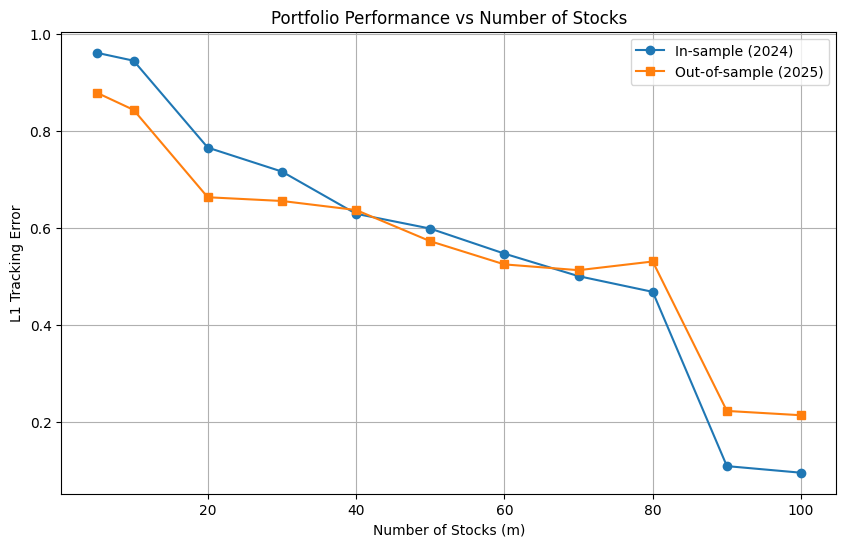

In [ ]:
# After computing results for all m values
df_results = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(df_results['m'], df_results['L1_2024'], marker='o', label='In-sample (2024)')
plt.plot(df_results['m'], df_results['L1_2025'], marker='s', label='Out-of-sample (2025)')
plt.xlabel('Number of Stocks (m)')
plt.ylabel('L1 Tracking Error')
plt.title('Portfolio Performance vs Number of Stocks')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def fit_sparse_weights_MIP_L1(rets_mat: np.ndarray, q_vec: np.ndarray, m: int, env, time_limit_sec=3600, nonneg=True, verbose=False):
    T, N = rets_mat.shape
    mdl = gp.Model("sparse_weight_fit_L1", env=env)
    mdl.Params.OutputFlag = 1 if verbose else 0
    mdl.Params.TimeLimit = time_limit_sec

    # Vars
    w = mdl.addVars(N, lb=0.0 if nonneg else -GRB.INFINITY, name="w")
    y = mdl.addVars(N, vtype=GRB.BINARY, name="y")
    e = mdl.addVars(T, lb=0.0, name="e")

    # abs value linearization
    for t in range(T):
        mdl.addConstr(e[t] >= q_vec[t] - gp.quicksum(w[j] * rets_mat[t, j] for j in range(N)))
        mdl.addConstr(e[t] >= -q_vec[t] + gp.quicksum(w[j] * rets_mat[t, j] for j in range(N)))

    # budget + sparsity
    mdl.addConstr(gp.quicksum(w[j] for j in range(N)) == 1.0)
    mdl.addConstr(gp.quicksum(y[j] for j in range(N)) == m)

    # big-M linking (M=1 is tight under nonneg + budget)
    M = 1.0
    for j in range(N):
        mdl.addConstr(w[j] <= M * y[j])

    mdl.setObjective(gp.quicksum(e[t] for t in range(T)), GRB.MINIMIZE)
    mdl.optimize()

    w_sol = np.array([w[j].X for j in range(N)])
    sel_idx = [j for j in range(N) if y[j].X > 0.5]
    total_L1 = sum(e[t].X for t in range(T))
    return w_sol, sel_idx, total_L1

In [ ]:
w_sparse_2024, sel_idx_sparse, L1_sparse_2024 = fit_sparse_weights_MIP_L1(
    R24, q24, m=20, time_limit_sec=3600, env=env, nonneg=True
)
L1_sparse_2025 = float(np.sum(np.abs(q25 - R25 @ w_sparse_2024)))
